<a href="https://colab.research.google.com/github/GrigoryBartosh/dul_2021/blob/main/Homework/hw12/Homework12_semisupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/Mogreine/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 466, done.
remote: Counting objects: 100% (271/271), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 466 (delta 153), reused 138 (delta 88), pack-reused 195
Receiving objects: 100% (466/466), 60.38 MiB | 30.52 MiB/s, done.
Resolving deltas: 100% (221/221), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=27645 sha256=748e9cfbb06952078180e8b76d578574e9ada9fc104285af7f4423adb89474c7
  Stored in directory: /tmp/pip-ephem-wheel-cache-c5f6fc7_/wheels/55/59/29/0fb1c635652

In [2]:
from dul_2021.utils.hw12_utils import *

In [3]:
!pip install torchmetrics

# Question 1. VAT

Here we will implement [VAT](https://arxiv.org/pdf/1704.03976.pdf).

* Train labeled data with standatd cross-entropy loss

* Use vat regularization for both unlabeled and labeled data

* You can use architecture from practice

* Dataset comes as pairs `x, y`. `x` is an image from CIFAR10. `y` is a label from `[0, 10]` if datapoint is labeled and `-1` otherwise.

**Hyperparameters**

* ξ= 10 
* lr = 5e-4
* num_epochs = 15



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. After each epoch calculate accuracy on test data.

In [29]:
import numpy as np
import torch
import torchmetrics

from tqdm import tqdm
from torch import nn
from torch.nn import functional as F

from utils.hw12_utils import *


class Classifier(nn.Module):
    def __init__(self, n_classes: int):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(128, n_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)


class VAT(nn.Module):
    def __init__(self, xi: float = 1):
        super().__init__()
        self.clf = Classifier(n_classes=10)
        self.acc = torchmetrics.Accuracy()
        self.xi = xi

    @property
    def device(self):
        return next(self.clf.parameters()).device

    def fit(self, train_dataloader, test_dataloader, n_epochs=10, lr=1e-4, device="cuda"):
        self.to(device)
        losses = []
        accs = []
        opt = torch.optim.Adam(self.clf.parameters(), lr=lr)
        for epoch in range(n_epochs):
            pbar = tqdm(train_dataloader, desc="Training...")
            for batch in pbar:
                imgs, labels = batch
                imgs = imgs.to(device)
                labels = labels.to(device)

                loss = self.__loss(imgs, labels)
                acc = self.__calc_acc(test_dataloader)

                losses.append(loss.item())
                accs.append(acc.item())

                opt.zero_grad()
                loss.backward()
                opt.step()

                pbar.set_postfix({"loss": losses[-1], "acc_val": accs[-1]})

        return np.array(losses), np.array(accs)

    def __loss(self, imgs, labels):
        labeled = labels != -1
        ce_loss = self.__loss_clf(imgs[labeled], labels[labeled])
        adv_loss = self.__loss_adv(imgs)
        return ce_loss + adv_loss

    def __loss_clf(self, imgs, labels):
        logits = self.clf(imgs)
        return F.cross_entropy(logits, labels)

    def __loss_adv(self, imgs):
        d = torch.randn_like(imgs).to(self.device)
        d = self.__normalize(d)

        r = self.xi * d
        r.requires_grad_(True)

        preds = F.softmax(self.clf(imgs), dim=1)
        r_adv = self.__direction_grad(imgs, preds, r)

        pred_hat = self.clf(imgs + r_adv)
        logp_hat = F.log_softmax(pred_hat, dim=1)
        loss = F.kl_div(logp_hat, preds, reduction="batchmean")

        return loss

    def __direction_grad(self, imgs, preds, r):
        pred_hat = self.clf(imgs + r)
        logp_hat = F.log_softmax(pred_hat, dim=1)

        adv_distance = F.kl_div(logp_hat, preds, reduction="batchmean")
        
        r_adv = torch.autograd.grad(adv_distance, r)[0]

        r_adv = self.__normalize(r_adv)
        return r_adv

    def __normalize(self, x: torch.Tensor) -> torch.Tensor:
        x_reshaped = x.view(x.shape[0], -1)
        x_reshaped_norm = F.normalize(x_reshaped, p=2, dim=1)
        x = x_reshaped_norm.view(x.shape)
        return x

    @torch.no_grad()
    def __calc_acc(self, dataloader):
        for batch in dataloader:
            imgs, labels = batch
            imgs = imgs.to(self.device)
            labels = labels.to(self.device)
            logits = self.clf(imgs)

            self.acc(logits.argmax(dim=-1), labels)

        acc = self.acc.compute()
        self.acc.reset()

        return acc


def create_dataloader(data, bs, shuffle=True):
    imgs, labels = zip(*data)
    imgs = torch.stack(imgs, dim=0)
    labels = torch.tensor(labels, dtype=torch.int64)

    dataset = torch.utils.data.TensorDataset(imgs, labels)

    return torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=shuffle)


In [30]:
def q1(train_data, test_data):
    """
    train_data: An (n_train, 3, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """
    torch.manual_seed(42)
    bs = 256
    lr = 4e-4
    n_epochs = 1
    device = "cuda"

    train_loader = create_dataloader(train_data, bs)
    test_loader = create_dataloader(test_data, bs, False)

    model = VAT()
    losses, accs = model.fit(train_loader, test_loader, n_epochs=n_epochs, lr=lr, device=device)

    return losses, accs

Files already downloaded and verified
Files already downloaded and verified


Training...: 100%|██████████| 196/196 [04:50<00:00,  1.48s/it, loss=1.63, acc_val=0.458]


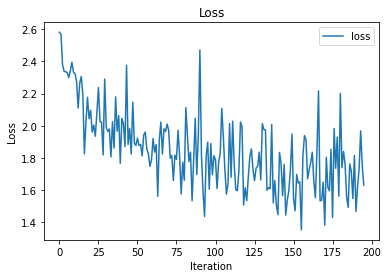

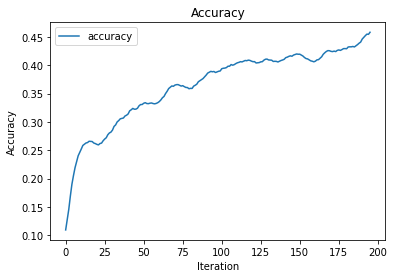

In [31]:
q12_results(q1)

# Question 2. FixMatch

Here we will implement [FixMatch](https://arxiv.org/abs/2001.07685).

* Calculate loss on weakly augmented labeled data with standatd cross-entropy loss

* Calculate loss on strongly augmented unlabeled data with standatd cross-entropy loss with pseudo-lables

* Use SimCLR transformations as strong and RandomHorizontalFlip as weak

* You can use architecture from practice

* Dataset comes as pairs `x, y`. `x` is an image from CIFAR10. `y` is a label from `[0, 10]` if datapoint is labeled and `-1` otherwise.

**Hyperparameters**

* τ = 0.7 
* λ_u = 10 (weight of unlabeled loss)
* lr = 5e-4
* num_epochs ~ 20 or more



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. After each epoch calculate accuracy on test data.

In [ ]:
def q2(train_data, test_data):
    """
    train_data: An (n_train, 3, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """

In [ ]:
q_results(q2)

# Bonus

## The probabilistic model

*(this is a short summary of the model presented in ["Semi-supervised Learning with
Deep Generative Models"](https://arxiv.org/pdf/1406.5298.pdf))*

In the semi-supervised setting, the generative model is a little more complicated than vanilla VAE. In particular, it incorporates a new variable $y$ that represents the class of a digit $x$.

\begin{align*}
& p(x, y, z) = p(x \mid y, z) p(z) p(y) \\
& p(y) = Cat(y \mid \pi_0), \pi_0 = (1/10, \dots, 1/10) \\
& p(z) = \mathcal N(z \mid 0, I) \\
& p(x \mid y, z) = \prod_{i=1}^D p_i(y, z)^{x_i} (1 - p_i(y, z))^{1 - x_i}
\end{align*}

## The first part of the objective

Whenever we train a probabilistic model with partial observations, we interpret the unobserved variables as latent variables. Then we marginalize them. In this case, the loss function splits into two terms: one for observed variables (we denote the set of indices of observed labels $P$), another for unobserved.

\begin{equation}
L(X, y) = \sum_{i \notin P} \log p(x_i) + \sum_{i \in P} \log p(x_i, y_i)
\end{equation}

Again, we can't compute the exact values of marginal likelihoods and resort to variational lower bound on likelihood. To compute lower bounds, we define the following variational approximation:

\begin{align*}
& q(y, z \mid x) = q(y \mid x) q(z \mid y, x)\\
& \\
& q(y \mid x) = Cat(y \mid \pi(x))\\
& q(z \mid y, x) = \mathcal N(z \mid \mu_\phi(x, y), \operatorname{diag}\sigma^2_\phi(y, x))
\end{align*}

Using the variational approximation, we will obtain two lower bounds.

First, the ELBO for $\log p(x_i, y_i)$ for the observed variables (this one is similar to ELBO of VAE).

\begin{equation}
\log p(x, y) = \log \mathbb E_{p(z)} p(x, y \mid z) \geq \mathbb E_{q(z \mid y, x)} \log \frac{p(x, y \mid z) p(z)}{q(z \mid y, x)}
\end{equation}

Second, the ELBO for $\log p(x_i)$ for the unobserved variables.

\begin{equation}
\log p(x) = \log \mathbb E_{p(y)} \mathbb E_{p(z \mid y)} \log p(x\mid z, y)\geq \mathbb E_{q(y \mid x)} \mathbb E_{q(z \mid y, x)} \log \frac{p(x, y \mid z) p(z)}{q(z \mid y, x) q(y \mid x)}
\end{equation}

Finally, the joint lower bound will be

\begin{equation}
\mathcal L(X, y) = \sum_{i \in P} \mathbb E_{q(z_i \mid y_i, x_i)} \log \frac{p(x_i, y_i \mid z_i) p(z_i)}{q(z_i \mid y_i, x_i)} + \sum_{i \notin P} \mathbb E_{q(y_i \mid x_i)} \mathbb E_{q(z_i \mid y_i, x_i)} \log \frac{p(x_i, y_i \mid z_i) p(z_i)}{q(z_i \mid y_i, x_i) q(y_i \mid x_i)}
\end{equation}

We will use reparametrized Monte-Carlo estimates to approximate expectation w.r.t. $z$. To approximate expectaion w.r.t. the discrete variable $y$ we will try three different options.

In [ ]:
def b(train_data, test_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of binary MNIST images
    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """